<a href="https://colab.research.google.com/github/akitim/SkillFactory_current/blob/main/MATH_ML_2_%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_%D0%90%D0%BA%D0%B8%D0%BC%D0%BA%D0%B8%D0%BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [ ]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков

%matplotlib inline

Прочитаем исходные данные:

In [ ]:
# data = pd.read_csv('sample_data/unconv.csv')
url = 'https://raw.githubusercontent.com/akitim/datasets/main/unconv.csv'
data = pd.read_csv(url)
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

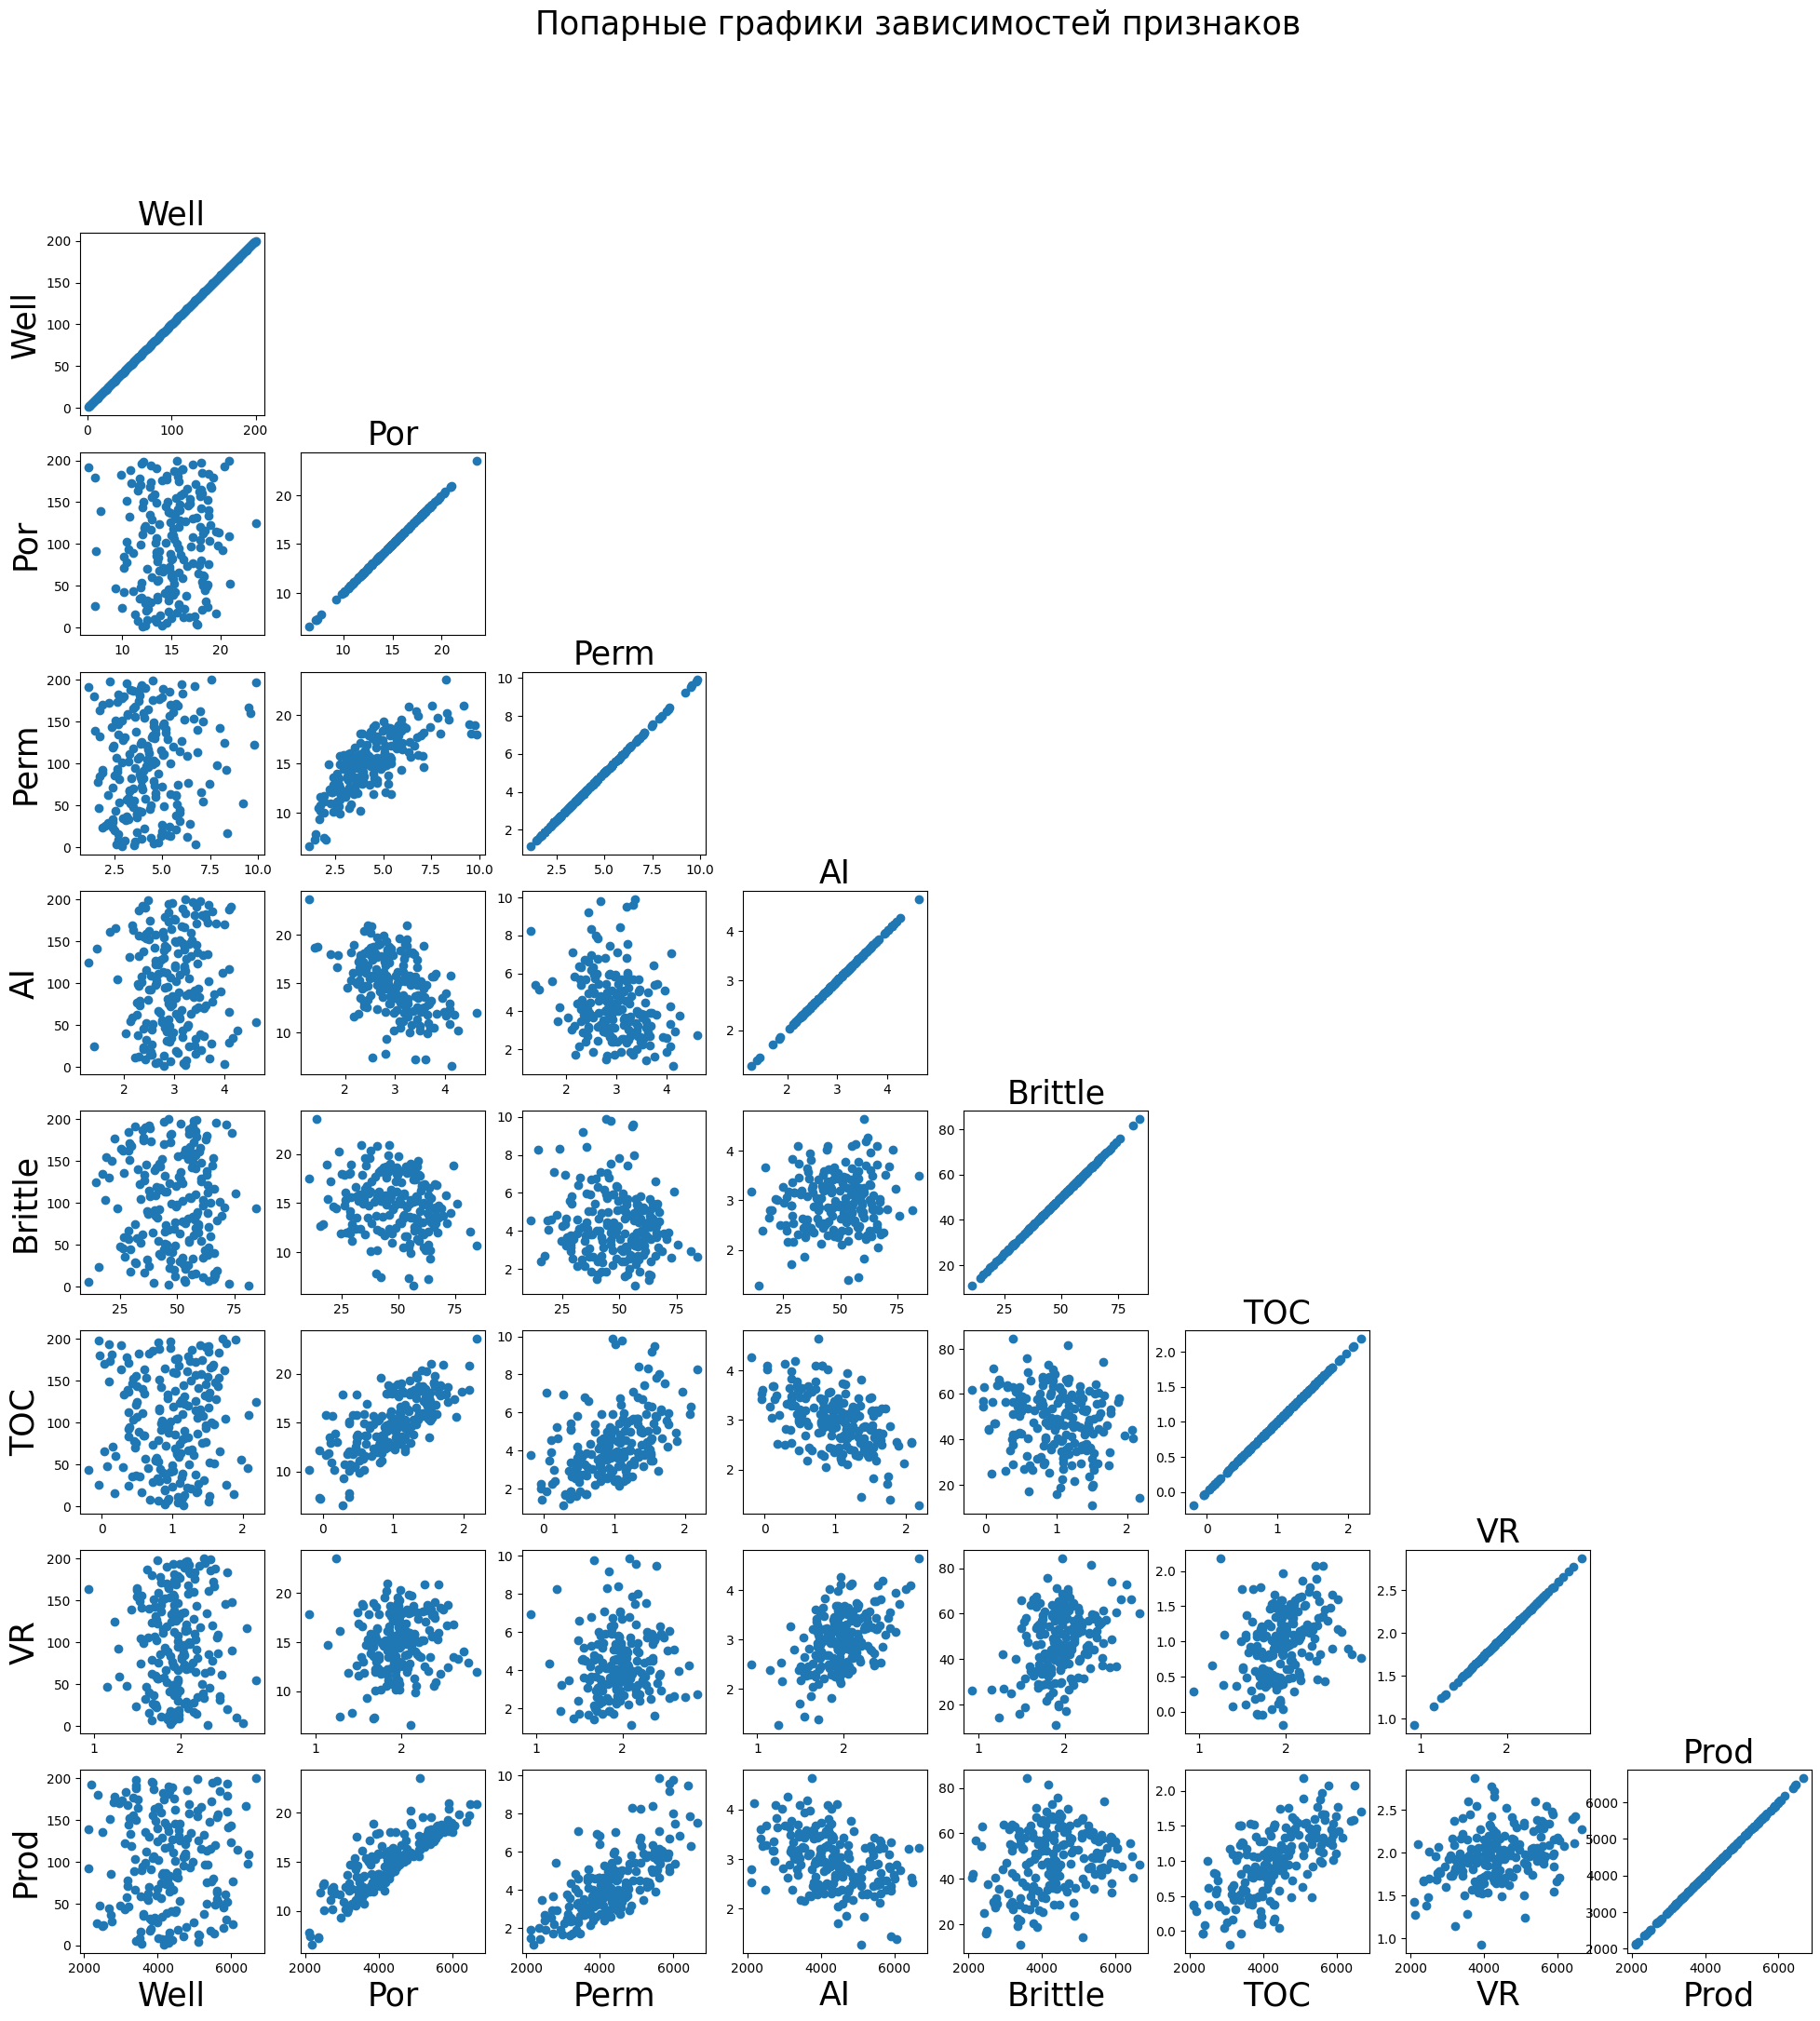

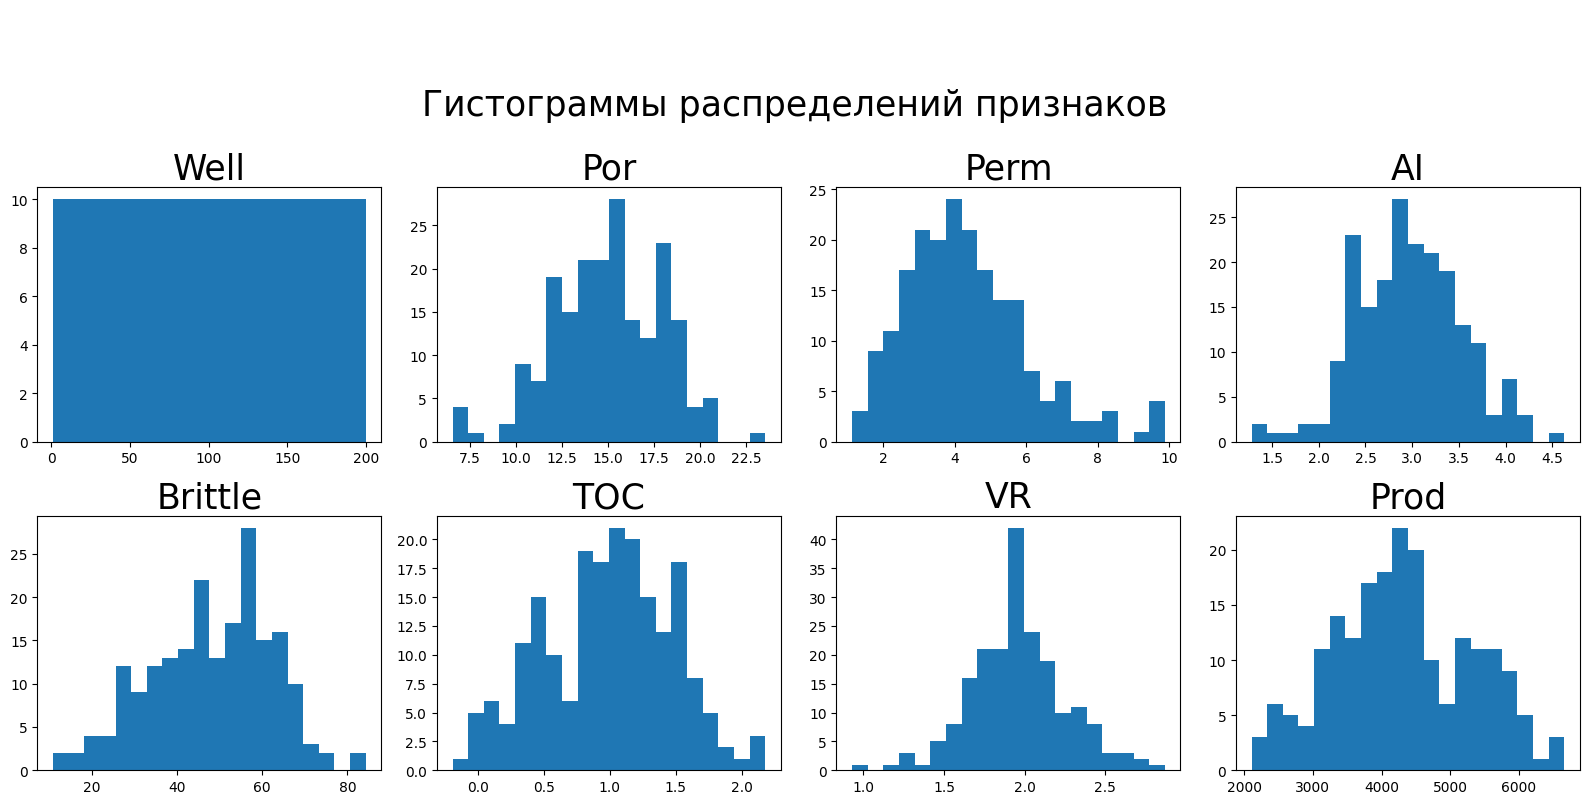

In [ ]:
# !pip install -U ydata-profiling
# !pip install ipywidgets

# from ydata_profiling import ProfileReport

# profile = ProfileReport(data, title="Pandas Profiling Report")
# profile

features = data.columns.to_list()
N = data.shape[1]

# строим попарные графики зависиомстей признаков друг от друга
fig = plt.figure(figsize=(24,24))
font_dict = {'fontsize': 25}
fig.suptitle('Попарные графики зависимостей признаков', fontsize=25)
for i in range(N - 1, -1, -1):
    for j in range(0, i + 1):
        ax_curr = plt.subplot2grid(shape=(N,N), loc=(i, j), fig=fig)
        ax_curr.scatter(data.iloc[:, i], data.iloc[:, j])
        if i == 7:
            plt.xlabel(data.iloc[:, j].name, fontdict=font_dict)
        if i == j:
            ax_curr.set_title(data.iloc[:, j].name, fontdict=font_dict)
        if j == 0:
            plt.ylabel(data.iloc[:, i].name, fontdict=font_dict)

# построим гистограммы распределений каждого из признаков
fig = plt.figure(figsize=(16,8), layout='tight');
fig.suptitle('\n\nГистограммы распределений признаков', y=1, fontsize=25)
n_rows = 2
for i in range(N):
    ax_curr = plt.subplot2grid(shape=(2, N//n_rows),
                               loc=(i//(N//n_rows), i % (N//n_rows)),
                               fig=fig);
    ax_curr.hist(data.iloc[:, i], bins=20);
    ax_curr.set_title(data.iloc[:, i].name, font_dict)

#===============================================================================
# Промежуточные выводы.

# 1) Данные чистые, пропуски отсутствуют.
# 2) Распределение значений признаков (за исключением Well) близки к нормальному.
# 2) Признак Well порядковый (является индентификатором скважины)
#    и не несет какой-либо информации.
# 3) Имеется сильная линейная зависимость между признаками Por, Perm, TOC и Prod,
#    а также TOC и AI.

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

Ранг корреляционной матрицы: 8
Определитель корреляционной матрицы: 0.0007


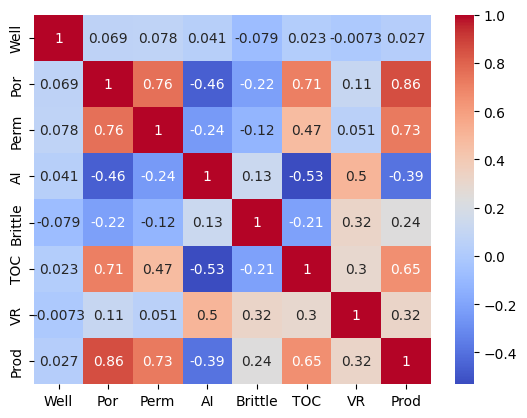

In [ ]:
#корреляционная матрица факторов
corr_matrix = data.corr()

#тепловая карта корреляций факторов
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True);

#ранг корреляционной матрицы
corr_matrix_rank = np.linalg.matrix_rank(corr_matrix)
print(f'Ранг корреляционной матрицы: {corr_matrix_rank}')

#определитель корреляционной матрицы
corr_matrix_det = np.linalg.det(corr_matrix)
print(f'Определитель корреляционной матрицы: {np.round(corr_matrix_det, 4)}')


Выводы.
--

---
0) Какие факторы сильнее всего коррелируют с целевой переменной?
--

Коэффициент корреляции |         |          |          |
-----------------------|-----    |------    |-----     |
Признаки               |***Por***|***Perm***|***TOC*** |
***Prod***             |   0.86  |   0.73   |   0.65   |
  

---

1) Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
--

Корреляционная матрица $(c_{ij})$ плохо обусловлена, т.к. $det(c_{ij})≈7\times10^{-4}.$

---

2) Что вы можете сказать о наличии коллинеарности/мультиколлинеарности в данных?
--

Поскольку ранг матрицы корреляций $(c_{ij})$ максимален(=8) коллинеарность признаков отсутсвует, однако $det(c_{ij})$ довольно близок к 0, что является признаком наличия мультиколлинеарности в данных.

---
3) Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему?
--

Модель классической линейной регрессии по методу МНК применима **только формально**, поскольку в данных имеется довольно сильная мультиколлинеарность между несколькими признаками (матрица корреляций признаков довольно близка к вырожденной). Полученные таким образом коэффициенты регрессии будут неустойчивыми и плохо интепретируемыми.

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [ ]:
# функция для отображения коэффициентов регрессии
def display_reg_coef(df_labels, w):
    tmp_labels = df_labels.copy()
    tmp_labels.insert(0, 'intercept')
    tmp_labels = [('w' + str(i), lbl) for i, lbl in enumerate(tmp_labels)]
    w_df = pd.DataFrame({tmp_labels[i]:[np.round(w[i])] for i in range(len(w))})
    w_df.set_index(pd.Index(['value']), inplace=True)
    
    print ("\nКоэффициенты регрессии:\n")
    display(w_df)

# матрица признаков
x = data.drop('Prod', axis=1).values

# матрица регрессоров
A = np.hstack((np.ones((x.shape[0], 1)), x))

# целевая переменная
y = data.loc[:, 'Prod'].values

w = np.linalg.inv(A.T @ A) @ A.T @ y

# выводим коэффициенты регрессии
df_labels = data.drop('Prod', axis=1).columns.to_list()
display_reg_coef(df_labels, w)



Коэффициенты регрессии:



,w0,w1,w2,w3,w4,w5,w6,w7
,intercept,Well,Por,Perm,AI,Brittle,TOC,VR
value,-1232.0,0.0,230.0,116.0,-365.0,25.0,-78.0,785.0


Выводы.
--
------------------------------
1) Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
--

Согласно модели влияние признака *Well* на целевую переменную *Prod* пренебрежимо мало.

------------------------------

2) Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.
--

Свободный коэффициент регрессии $Intercept(w_{0})$ имеет значение $≈-1232$. Коэффициент показывает производительность скважины, когда все остальные параметры скважины равны нулю. Имеет тот же порядок величины, что и значение средней добычи на отдельной скважине $(≈4000)$, т.е. оказывает довольно сильное влияние на модельное значение добычи. Отрицательное значение этого коэффициента означает, что чтобы скважина имела ненулевую производительность, нужно чтобы остальные коэффициенты превышали некоторое пороговое значение.

Коэффициент регрессии $w_2$ для признака $Por$ имеет второе по величине значение из положительных коэффициентов, что согласуется с высоким  коэффициентом корреляции ($0.86$) данного признака и целевой переменной. Увеличение пористости на 1% дает прирост добычи газа на скважине на 230 $\frac{10^6фут^3}{сутки}$.






 

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [ ]:
# функция для расчета и вывода метрик
def calculate_metrics(y_true, y_pred,
                      k, #кол-во параметров в модели
                      metrics):
    calculated = []
    print('')
    for metric in metrics:
        if metric == 'MAPE': #ср. абсолютная ошибка в процентах
            metric_value = np.mean(np.abs(y_pred - y_true) / y_true) * 100
        elif metric == 'R2_adj': #скорректированный коэф. детерминации
            n = y_true.size #кол-во наблюдений
            S_res = np.sum((y_pred - y) ** 2)
            S_tot = np.sum((np.mean(y) - y) ** 2)
            metric_value = 1 - S_res / (n - k) / (S_tot / (n - 1))

 
        print(f'{metric} = {metric_value}')
        calculated += [metric_value]

    return calculated

# а) Прогноз на новых данных для 1 скважины
well_params = {
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
x_pred_0 = np.array([1] + list(well_params.values()))

# прогноз
y_pred_0 = w @ x_pred_0
print (f'Прогноз добычи на скважине с параметрами \n{well_params}'
+ f'\nсоставляет {y_pred_0} млн. куб. фут/сутки')

# абсолютная ошибка прогноза ()
y_true_0 = 4748.315024
abs_error = np.abs(y_true_0 - y_pred_0)
print (f'\nАбсолютная ошибка прогноза составляет ≈{np.round(abs_error)} млн. куб. фут/сутки')

# б) Расчет метрик
y_pred = A @ w

metrics = calculate_metrics(y, y_pred, w.size, ['MAPE', 'R2_adj'])


Прогноз добычи на скважине с параметрами 
{'Well': 106.0, 'Por': 15.32, 'Perm': 3.71, 'AI': 3.29, 'Brittle': 55.99, 'TOC': 1.35, 'VR': 2.42}
составляет 4723.064053707485 млн. куб. фут/сутки

Абсолютная ошибка прогноза составляет ≈25.0 млн. куб. фут/сутки

MAPE = 3.6279468451333132
R2_adj = 0.9583868576924219


Выводы.
--
----------------
Значение метрики MAPE показывает, что предсказанные моделью значения в среднем отклоняются от реальных данных не более чем на $≈3.6 \%$.

Значение метрики R2_adj показывает, что $≈95.8\%$ дисперсии целевой переменной объясняется выбранной моделью.

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

In [ ]:
#сравниваем выборочные корелляции признаков с целевой переменной
# с коэффициентами регрессии
comparison_df = corr_matrix[['Prod']].drop(['Prod'])
comparison_df.insert(loc=1, column='', value=w[1:])
comparison_df.columns = ['correlation', 'reg coef']
comparison_df.index = pd.MultiIndex.from_tuples(
    list(zip(['w' + str(i) for i in range(1, 8)], comparison_df.index)
    ))
display(comparison_df)


,,correlation,reg coef
w1,Well,0.026817,0.050700
w2,Por,0.861910,230.179140
w3,Perm,0.727426,116.239006
w4,AI,-0.390835,-365.202301
w5,Brittle,0.237155,24.994370
w6,TOC,0.654445,-78.400929
w7,VR,0.323182,785.259815


Выводы.
--

Коэффициент регрессии $w_6$ и соответствующий ему признак $TOC$ противоречат друг другу (имеют разные знаки).

Возможно, это связано с плохой обусловленностью корелляционной матрицы признаков.

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [ ]:
from itertools import combinations

target = 'Prod'
feat_corr_threshold = 0.7
target_corr_threshold = 0.05

features = data.columns.to_list() # список всех признаков
features_ = data.drop(target, axis=1).columns.to_list() #список признаков без целевой
# print(features, features_)

# ищем пары 'независимых' признаков, коррелирующие между собой выше порога 
correlated_features_pairs = [
    [p1, p2] for p1, p2 in combinations(features_, 2)
    if corr_matrix.loc[p1, p2] > feat_corr_threshold
 ]

# составляем список признаков на удаление - 
# смотрим  на корреляцию с целевой переменной
features_to_drop = []
for p1, p2 in correlated_features_pairs:
    if  corr_matrix.loc[p1, target] >= corr_matrix.loc[p2, target]\
        and p1 not in features_to_drop:
        features_to_drop += [p2]
    elif p2 not in features_to_drop:
        features_to_drop += [p1]

# добавляем в список признаки, корр. с целевой ниже порога
features_to_drop += list(
    corr_matrix.loc[:, target][
        np.abs(corr_matrix.loc[:, target]) < target_corr_threshold
        ].index)
print('Будут удалены признаки:\n', *features_to_drop)

# новая матрица признаков
x_upd = data.drop(features_to_drop + [target], axis=1).values

# новая матрица регрессоров, включая столбец единиц
A_upd = np.hstack((np.ones((x_upd.shape[0], 1)), x_upd))

# новые коэффициенты регрессии
w_upd = np.linalg.inv(A_upd.T @ A_upd) @ A_upd.T @ y

# выводим коэффициенты регрессии
df_labels = data.drop(features_to_drop + [target], axis=1).columns.to_list()
display_reg_coef(df_labels, w_upd)

# Расчет метрик
y_pred_upd = A_upd @ w_upd

metrics = calculate_metrics(y, y_pred_upd, w_upd.size, ['MAPE', 'R2_adj'])


Будут удалены признаки:
 Perm TOC Well

Коэффициенты регрессии:



,w0,w1,w2,w3,w4
,intercept,Por,AI,Brittle,VR
value,-1835.0,293.0,-200.0,28.0,517.0



MAPE = 4.04413842043606
R2_adj = 0.9440762880179219


Выводы.
--

----------------
1) Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
--

Свободный коэффициент регрессии $Intercept(w_{0})$ имеет значение $≈-1835$. Коэффициент показывает производительность скважины, когда все остальные параметры скважины равны нулю. Имеет тот же порядок величины, что и значение средней добычи на отдельной скважине $(≈4000)$, т.е. оказывает довольно сильное влияние на предсказываемое значение добычи. По сравнению с предыдущей итерацией модели коэффициент не изменил знака и вырос по модулю. 

Коэффициент регрессии $w_2$ для признака $Por$ имеет самое большое значение из положительных коэффициентов, также как и в предыдущей итерации модели. Увеличение пористости на 1% дает прирост добычи газа на скважине на 293 $\frac{10^6фут^3}{сутки}$, что согласуется с интуитивным ожиданием о влиянии пористости породы на выход газа из скважины. По сравнению с предыдущей моделью, значение коэффициента выросло, т.к. в текущей модели меньшее кол-во регрессоров, а значения целевой переменной не изменились.

---------------
2) Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее.
--

Значение метрики MAPE показывает, что предсказанные моделью значения в среднем отклоняются от реальных данных не более чем на $≈4.4 \%$. Значение метрики MAPE выросло на $0.8\%$.

Значение метрики $R^2_{adj}$ показывает, что $≈94.4\%$ дисперсии целевой переменной объясняется выбранной моделью. 

---------------

3) Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?
--

Коэффициенты регрессии и соответствующие им признаки имеют одинаковые знаки, т.к. признак $TOC$, имевший корреляцию с целевой переменной, противоположную по знаку соответствующему коэффициенту регрессии $w_6$, исключен из модели.


### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape, r2_score

# строим регрессию
lr = LinearRegression(fit_intercept=True, n_jobs=-1)
lr.fit(x_upd, y)

# получаем прогноз на обучающем наборе данных
y_pred_sk = lr.predict(x_upd)

# вектор коэффициентов регрессии
w_sk = np.append([lr.intercept_], lr.coef_)

# результаты
display_reg_coef(df_labels, w_sk)
print ('\nМетрики:')
metrics_sk = calculate_metrics(
    y_true=y, y_pred=y_pred_sk, k=w_sk.size, metrics=['MAPE', 'R2_adj']
    )



Коэффициенты регрессии:



,w0,w1,w2,w3,w4
,intercept,Por,AI,Brittle,VR
value,-1835.0,293.0,-200.0,28.0,517.0



Метрики:

MAPE = 4.044138420436028
R2_adj = 0.9440762880179219


Выводы.
--
---
Значения коэффициентов модели, полученной методом МНК с помощью библиотеки numpy, и линейной регрессии, реализованной в библиотеке scikit-learn, полностью совпадают.
Соответственно совпадают и метрики $MAPE$ и $R^2_{adj}$.

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [4]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')


### Задание 8.1. (1 балл)

Стандартизируйте признаки с помощью `StandardScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [5]:
url = 'https://raw.githubusercontent.com/akitim/datasets/main/unconv.csv'
data = pd.read_csv(url)
features_to_drop = ['Perm', 'TOC', 'Well', 'Prod']
x_upd = data.drop(features_to_drop, axis=1).values
y = data['Prod'].values
# ------------------------------------
# словарь для результатов применения разных моделей регрессии
models_eval_res = {}
# ------------------------------------
x_st = StandardScaler().fit_transform(x_upd)

# генерируем полиномиальные признаки
x_poly = PolynomialFeatures(degree=3,
                            include_bias=False).fit_transform(x_st)
print('После генерации полиномиальных признаков всего получилось признаков:',
      x_poly.shape[1])

# строим модель
linreg = LinearRegression(fit_intercept=True)

# пользовательская функция для расчета скорректированного
# коэффициента детерминации R2_adj при кросс-валидации,
# поскольку она отсутствует в наборе метрик библиотеки sklearn
def R2_adj_scorer(estimator, X, y_true):
    n = X.shape[0] # кол-во наблюдений
    k = X.shape[1] # кол-во признаков
    y_pred = estimator.predict(X)
    
    # расчет метрики
    S_res = np.sum((y_pred - y_true) ** 2)
    S_tot = np.sum((np.mean(y_true) - y_true) ** 2)

    return 1 - S_res / (n - k) / (S_tot / (n - 1))

# оцениваем качество модели на кросс-валидации, метрики — MAPE и R2_adj
cv_result = cross_validate(
    linreg, x_poly, y,
    scoring={'nMAPE':'neg_mean_absolute_percentage_error',
            'R2_adj': R2_adj_scorer},
    cv=5, return_train_score=True
)

MAPE_cv_train, R2_adj_cv_train = \
-np.mean(cv_result['train_nMAPE']) * 100, np.mean(cv_result['train_R2_adj'])
MAPE_cv_test, R2_adj_cv_test = \
-np.mean(cv_result['test_nMAPE']) * 100, np.mean(cv_result['test_R2_adj'])

print('\nРезультаты кросс-валидации на 5 фолдах:')
models_eval_res['linreg_cv'] = pd.DataFrame(
    {'train': [MAPE_cv_train, R2_adj_cv_train],
     'validation': [MAPE_cv_test, R2_adj_cv_test]},
      index = ['mean MAPE', 'mean R2_adj'])
display(models_eval_res['linreg_cv'])


После генерации полиномиальных признаков всего получилось признаков: 34

Результаты кросс-валидации на 5 фолдах:


,train,validation
mean MAPE,1.773240,2.680875
mean R2_adj,0.986899,0.835914


На валидационных фолдах по сравнению с обучающим фолдом происходит  значительное ухудшение среднего метрик: рост $MAPE$ c $1.77\%$ до $2.68\%$ и сильное уменьшение $R^2_{adj}$ c $0.99$ до $0.84$. Очевидно, что в отсутствие регуляризации происходит переобучение полиномиальной регрессии.

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [10]:
RND_SEED = 42

# стандартизация признаков
x_poly_st = StandardScaler().fit_transform(x_poly)

# модель
lasso = Lasso(fit_intercept=True)

# функция для оптимизации гиперпараметров с кроссвалидацией
# и вывода результатов
def hyperparam_cv_optimizer(estimator, X, y, 
                            method, hyperparams, scoring, refit=False,
                            cv=5, n_iter=100, rnd_state=42):
    if method=='GridSearchCV':
        # оптимизация коэффициента регуляризации - исчерпывающий поиск по сетке
        gs = GridSearchCV(
            estimator,
            param_grid=hyperparams,
            scoring=scoring,
            refit=refit,
            cv=cv,
            return_train_score=True
        )
        gs.fit(X, y);

        # вывод результатов(работает только для пары метрик MAPE и R2_adj)
        df_est = pd.DataFrame(gs.cv_results_).loc[:,
         ['param_alpha', 'mean_train_R2_adj', 'mean_test_R2_adj',
         'mean_train_nMAPE', 'mean_test_nMAPE']]
        df_est[['mean_train_nMAPE', 'mean_test_nMAPE']] *= -100
        df_est.rename(columns={'mean_train_nMAPE': 'mean_train_MAPE',
                    'mean_test_nMAPE': 'mean_test_MAPE',
                    'param_alpha': 'alpha'}, inplace=True)

        # параметр alpha, на котором метрики достигают лучших значений
        ind_r2_max_gs = df_est['mean_test_R2_adj'].argmax()
        ind_mape_min_gs = df_est['mean_test_MAPE'].argmin()

        print('\nGridSearchCV results:\n')
        display(df_est)
        best_alpha = {'MAPE': df_est.loc[ind_mape_min_gs, 'alpha'],
                      'R2_adj': df_est.loc[ind_r2_max_gs, 'alpha']}
        print('Оптимальное зн-е alpha по метрике MAPE:', best_alpha['MAPE'])
        print('Оптимальное зн-е alpha по метрике R2_adj:', best_alpha['R2_adj']) 

        print(f'\nЛучшее значение метрик для {estimator.__str__()[:-2]}' + 
              f'-регрессии на {n_folds} фолдах')
        df_best_metrics = pd.DataFrame(
            {'mean MAPE':
             df_est.loc[ind_mape_min_gs, ['mean_train_MAPE',
                                             'mean_test_MAPE']].values,
             'mean R2_adj':
             df_est.loc[ind_r2_max_gs, ['mean_train_R2_adj',
                                             'mean_test_R2_adj']].values},
             index = ['train', 'validation']).T
        display(df_best_metrics)
        print('=' * 80 + '\n' + '=' * 80)

    elif method=='RandomizedSearchCV':
    # оптимизация коэф. регуляризации - случайный поиск по сетке
        rs = RandomizedSearchCV(
            estimator,
            param_distributions=hyperparams,
            n_iter=n_iter,
            scoring={'nMAPE': 'neg_mean_absolute_percentage_error',
                    'R2_adj': R2_adj_scorer},
            refit=refit,   
            cv=cv, random_state = rnd_state, verbose=0,
            return_train_score=True
        )
        rs.fit(X, y);

        # вывод результатов
        df_est = pd.DataFrame(rs.cv_results_).loc[:,
         ['param_alpha', 'mean_train_R2_adj', 'mean_test_R2_adj',
         'mean_train_nMAPE', 'mean_test_nMAPE']]
        df_est[['mean_train_nMAPE', 'mean_test_nMAPE']] *= -100
        df_est.rename(columns={'mean_train_nMAPE': 'mean_train_MAPE',
                    'mean_test_nMAPE': 'mean_test_MAPE',
                    'param_alpha': 'alpha'}, inplace=True) 

        # параметр alpha, на котором метрики достигают лучших значений
        ind_r2_max_rs = df_est['mean_test_R2_adj'].argmax()
        ind_mape_min_rs = df_est['mean_test_MAPE'].argmin()

        print('\nRandomizedSearchCV results:\n') 
        display(df_est)
        best_alpha = {'MAPE': df_est.loc[ind_mape_min_rs, 'alpha'],
                      'R2_adj': df_est.loc[ind_r2_max_rs, 'alpha']}
        print('Оптимальное зн-е alpha по метрике MAPE:', best_alpha['MAPE'])
        print('Оптимальное зн-е alpha по метрике R2_adj:', best_alpha['R2_adj'])

        print(f'\nЛучшее значение метрик для ' +
              f'{estimator.__str__().split("(")[0]}' + 
              f'-регрессии на {n_folds} фолдах')
        df_best_metrics = pd.DataFrame(
            {'mean MAPE':
             df_est.loc[ind_mape_min_rs, ['mean_train_MAPE',
                                             'mean_test_MAPE']].values,
             'mean R2_adj':
             df_est.loc[ind_r2_max_rs, ['mean_train_R2_adj',
                                             'mean_test_R2_adj']].values},
             index = ['train', 'validation']).T
        display(df_best_metrics)
        
        print('=' * 80 + '\n' + '=' * 80)
    return {'cv_res': df_est, 'best_metrics': df_best_metrics,
            'best_alpha': best_alpha}

# оптимизация гиперпараметра alpha
alpha_grid = {'alpha': np.logspace(-0.5, 1.5, 11)}
scoring_dict = {'nMAPE': 'neg_mean_absolute_percentage_error',
           'R2_adj': R2_adj_scorer}
n_folds = 5
models_eval_res['Lasso_cv'] = {}
models_eval_res['Lasso_cv']['GridSearchCV'] = hyperparam_cv_optimizer(
    estimator=lasso, X=x_poly_st, y=y,
    method='GridSearchCV', hyperparams=alpha_grid,
    scoring=scoring_dict, refit='nMAPE',
    cv=n_folds, n_iter=100, rnd_state=RND_SEED
    )['best_metrics']

models_eval_res['Lasso_cv']['RandomizedSearchCV'] = hyperparam_cv_optimizer(
    estimator=lasso, X=x_poly_st, y=y,
    method='GridSearchCV', hyperparams=alpha_grid,
    scoring=scoring_dict, refit='nMAPE',
    cv=n_folds, n_iter=100, rnd_state=RND_SEED
    )['best_metrics']


GridSearchCV results:



,alpha,mean_train_R2_adj,mean_test_R2_adj,mean_train_MAPE,mean_test_MAPE
0,0.316228,0.986732,0.853942,1.771427,2.521061
1,0.501187,0.986615,0.857882,1.776802,2.471083
2,0.794328,0.986433,0.862971,1.788693,2.420223
3,1.258925,0.986170,0.870969,1.796348,2.355890
4,1.995262,0.985817,0.878822,1.807965,2.289664
5,3.162278,0.985257,0.885405,1.826855,2.227902
6,5.011872,0.984234,0.885987,1.884288,2.223533
7,7.943282,0.982237,0.879478,1.999025,2.308385
8,12.589254,0.979972,0.876482,2.110893,2.351825
9,19.952623,0.976197,0.859770,2.299184,2.472684


Оптимальное зн-е alpha по метрике MAPE: 5.011872336272725
Оптимальное зн-е alpha по метрике R2_adj: 5.011872336272725

Лучшее значение метрик для Lasso-регрессии на 5 фолдах


,train,validation
mean MAPE,1.884288,2.223533
mean R2_adj,0.984234,0.885987



GridSearchCV results:



,alpha,mean_train_R2_adj,mean_test_R2_adj,mean_train_MAPE,mean_test_MAPE
0,0.316228,0.986732,0.853942,1.771427,2.521061
1,0.501187,0.986615,0.857882,1.776802,2.471083
2,0.794328,0.986433,0.862971,1.788693,2.420223
3,1.258925,0.986170,0.870969,1.796348,2.355890
4,1.995262,0.985817,0.878822,1.807965,2.289664
5,3.162278,0.985257,0.885405,1.826855,2.227902
6,5.011872,0.984234,0.885987,1.884288,2.223533
7,7.943282,0.982237,0.879478,1.999025,2.308385
8,12.589254,0.979972,0.876482,2.110893,2.351825
9,19.952623,0.976197,0.859770,2.299184,2.472684


Оптимальное зн-е alpha по метрике MAPE: 5.011872336272725
Оптимальное зн-е alpha по метрике R2_adj: 5.011872336272725

Лучшее значение метрик для Lasso-регрессии на 5 фолдах


,train,validation
mean MAPE,1.884288,2.223533
mean R2_adj,0.984234,0.885987


> *Ваши выводы здесь*


### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [7]:
# модель
ridge = Ridge(fit_intercept=True, max_iter=1000, random_state=RND_SEED)

# параметры для оптимизации alpha
alpha_grid = {'alpha': np.logspace(-0.5, 1.5, 11)}
scoring_dict = {'nMAPE': 'neg_mean_absolute_percentage_error',
                'R2_adj': R2_adj_scorer}
n_folds = 5

# оптимизация
models_eval_res['Ridge_cv'] = hyperparam_cv_optimizer(estimator=lasso, X=x_poly_st, y=y,
                        method='GridSearchCV', hyperparams=alpha_grid,
                        scoring=scoring_dict, refit='nMAPE',
                        cv=n_folds, n_iter=100, rnd_state=RND_SEED
                                                      )['best_metrics']



GridSearchCV results:



,alpha,mean_train_R2_adj,mean_test_R2_adj,mean_train_MAPE,mean_test_MAPE
0,0.316228,0.986732,0.853942,1.771427,2.521061
1,0.501187,0.986615,0.857882,1.776802,2.471083
2,0.794328,0.986433,0.862971,1.788693,2.420223
3,1.258925,0.986170,0.870969,1.796348,2.355890
4,1.995262,0.985817,0.878822,1.807965,2.289664
5,3.162278,0.985257,0.885405,1.826855,2.227902
6,5.011872,0.984234,0.885987,1.884288,2.223533
7,7.943282,0.982237,0.879478,1.999025,2.308385
8,12.589254,0.979972,0.876482,2.110893,2.351825
9,19.952623,0.976197,0.859770,2.299184,2.472684


Оптимальное зн-е alpha по метрике MAPE: 5.011872336272725
Оптимальное зн-е alpha по метрике R2_adj: 5.011872336272725

Лучшее значение метрик для Lasso-регрессии на 5 фолдах


,train,validation
mean MAPE,1.884288,2.223533
mean R2_adj,0.984234,0.885987


> *Ваши выводы здесь

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [15]:
elnet = ElasticNet(fit_intercept=True, max_iter=1000, random_state=RND_SEED)

n_folds = 5
param_grid = {'alpha': np.logspace(0.5, 1.5, 11),
               'l1_ratio': np.logspace(-0.5, 0.5, 11)}

gs_elnet = GridSearchCV(
    elnet,
    param_grid=param_grid,
    scoring={'nMAPE': 'neg_mean_absolute_percentage_error',
             'R2_adj': R2_adj_scorer},
    refit='R2_adj',
    cv=n_folds,
    return_train_score=True
)
gs_elnet.fit(x_poly_st, y);

# вывод результатов
df_elnet_gs = pd.DataFrame(gs_elnet.cv_results_).loc[:,
 ['param_alpha', 'param_l1_ratio', 
  'mean_train_R2_adj', 'mean_test_R2_adj',
  'mean_train_nMAPE', 'mean_test_nMAPE']]
df_elnet_gs[['mean_train_nMAPE', 'mean_test_nMAPE']] *= -100
df_elnet_gs.rename(columns={'mean_train_nMAPE': 'mean_train_MAPE',
                    'mean_test_nMAPE': 'mean_test_MAPE',
                    'param_alpha': 'alpha',
                    'param_l1_ratio': 'l1_ratio'}, inplace=True)

# параметры регуляризации, на котором метрики достигают лучших значений
ind_r2_max_gs_elnet = df_elnet_gs['mean_test_R2_adj'].argmax()
ind_mape_min_gs_elnet = df_elnet_gs['mean_test_MAPE'].argmin()

print('\nGridSearchCV results:\n')
display(df_elnet_gs.dropna())
print("Оптимальные зн-я по метрике R2_adj:\n" +
      f"alpha: {df_elnet_gs.loc[ind_r2_max_gs_elnet, 'alpha']}; " + 
      f"l1_ratio: {df_elnet_gs.loc[ind_r2_max_gs_elnet, 'l1_ratio']}")
print("\nОптимальное зн-я по метрике MAPE:\n",
      f"alpha: {df_elnet_gs.loc[ind_mape_min_gs_elnet, 'alpha']}; " + 
      f"l1_ratio: {df_elnet_gs.loc[ind_mape_min_gs_elnet, 'l1_ratio']}")

print(f'\nЛучшее значение метрик для {elnet.__str__().split("(")[0]}' + 
    f'-регрессии на {n_folds} фолдах')
models_eval_res['ElasticNet'] = pd.DataFrame(
    {'train': 
     df_elnet_gs.loc[ind_r2_max_gs_elnet, ['mean_train_MAPE',
                                          'mean_train_R2_adj']].values,
     'validation': 
     df_elnet_gs.loc[ind_mape_min_gs_elnet, ['mean_test_MAPE',
                                           'mean_test_R2_adj']].values},
     index = ['mean MAPE', 'mean R2_adj'])
display(models_eval_res['ElasticNet'])
print('=' * 80 + '\n' + '=' * 80)



GridSearchCV results:



,alpha,l1_ratio,mean_train_R2_adj,mean_test_R2_adj,mean_train_MAPE,mean_test_MAPE
0,3.162278,0.316228,0.598843,-1.245744,11.015667,11.585960
1,3.162278,0.398107,0.631266,-1.074452,10.500466,11.076146
2,3.162278,0.501187,0.675933,-0.837086,9.749618,10.333000
3,3.162278,0.630957,0.739323,-0.496292,8.613317,9.167779
4,3.162278,0.794328,0.833890,0.022647,6.776797,7.320640
...,...,...,...,...,...,...
111,31.622777,0.398107,-0.013318,-4.379129,18.171908,18.420565
112,31.622777,0.501187,0.023058,-4.197567,17.826750,18.093672
113,31.622777,0.630957,0.089541,-3.863324,17.179202,17.474085
114,31.622777,0.794328,0.243317,-3.080207,15.600936,15.981766


Оптимальные зн-я по метрике R2_adj:
alpha: 3.9810717055349722; l1_ratio: 1.0

Оптимальное зн-я по метрике MAPE:
 alpha: 3.9810717055349722; l1_ratio: 1.0

Лучшее значение метрик для ElasticNet-регрессии на 5 фолдах


,train,validation
mean MAPE,1.850809,2.218065
mean R2_adj,0.984815,0.887192


> *Ваши выводы здесь*

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [18]:

# df_lr_cv, lasso_gs_res['best_metrics'], ridge_gs_res['best_metrics'], df_elnet_res
hyperparam_cv_optimizer(
    estimator=lasso, X=x_poly_st, y=y,
    method='GridSearchCV', hyperparams=alpha_grid,
    scoring=scoring_dict, refit='nMAPE',
    cv=n_folds, n_iter=100, rnd_state=RND_SEED
    )['best_metrics']




GridSearchCV results:



,alpha,mean_train_R2_adj,mean_test_R2_adj,mean_train_MAPE,mean_test_MAPE
0,0.316228,0.986732,0.853942,1.771427,2.521061
1,0.501187,0.986615,0.857882,1.776802,2.471083
2,0.794328,0.986433,0.862971,1.788693,2.420223
3,1.258925,0.986170,0.870969,1.796348,2.355890
4,1.995262,0.985817,0.878822,1.807965,2.289664
5,3.162278,0.985257,0.885405,1.826855,2.227902
6,5.011872,0.984234,0.885987,1.884288,2.223533
7,7.943282,0.982237,0.879478,1.999025,2.308385
8,12.589254,0.979972,0.876482,2.110893,2.351825
9,19.952623,0.976197,0.859770,2.299184,2.472684


Оптимальное зн-е alpha по метрике MAPE: 5.011872336272725
Оптимальное зн-е alpha по метрике R2_adj: 5.011872336272725

Лучшее значение метрик для Lasso-регрессии на 5 фолдах


,train,validation
mean MAPE,1.884288,2.223533
mean R2_adj,0.984234,0.885987


,train,validation
mean MAPE,1.884288,2.223533
mean R2_adj,0.984234,0.885987


In [ ]:
# удалить
# pd.merge(left=df_lr_cv, right=lasso_gs_res['best_metrics'],
#          how='left', )
# df_lr_cv.join(lasso_gs_res['best_metrics'], lsuffix='_', rsuffix='_')
# [val for col in df_lr_cv for val in df_lr_cv[col]], df_lr_cv
final_table = pd.concat
pd.concat([df_lr_cv.loc[['mean MAPE'], :], df_lr_cv.loc[['mean R2_adj'], :]],
          axis=0)
# d_ = {1: 'q', 2: 'w'}


> *Ваши выводы здесь*